# L3: Topic Models
### 732A92/TDDE16 Text Mining
MÃ¥ns Magnusson

The purpose of this lab is to implement the standard Gibbs sampling algorithm for Latent Dirichlet Allocation in Python. You will be supplied starter code, a smaller corpus with State of the Union addresses for the period 1975 to 2000 by paragraph and a list with English stop words. The code is implemented as a class, `LDAGibbs`, where you are expected to replace central parts of the code with your own implementations.

### 1. Sampling

Implement the basic collapsed Gibbs sampling algorithm for Latent Dirichlet Allocation. Use the starter code and add the components that is missing (the sampler part). We use the fact that 

$$p(z_{i}=k)\propto\left(\alpha+n_{d,k}^{(d)}\right)\frac{\left(\beta+n_{k,w_{i}}^{(w)}\right)}{\sum^{V}\left(\beta+n_{k,w_{i}}^{(w)}\right)}=\left(\alpha+n_{d,k}^{(d)}\right)\frac{\left(\beta+n_{k,w_{i}}^{(w)}\right)}{V\beta+n_{k}}$$

to simplify computations, where $K$ is the number of topics, $V$ is the vocabulary size and $D$ is the number of documents. $\mathbf{n}^{(d)}$ is a count matrix of size $D\times K$ with the number of topic indicators by document, $d$, and topic $k$, $\mathbf{n}^{(w)}$ is a count matrix of size $K\times V$ with the number of topic indicators by topic, $k$, and word type, $w$. $\mathbf{n}$ is a topic indicator count vector of length $K$ that contain the number of topic indicators in each topic. The detailed algorithm can be found below:

__Data:__ tokenized corpus $\mathbf{w}$, priors $\alpha, \beta$ <br>
__Result:__ topic indicators $\mathbf{z}$

Init topic indicators $\mathbf{z}$ randomly per token<br>
Init topic probability vector $\mathbf{p}$<br>
Init $\mathbf{n}^{w}$, the topic type count matrix of size ($K \times V$) with respect to $\mathbf{z}$<br>
Init $\mathbf{n}^{d}$, the document topic count matrix of size ($D \times K$) with respect to $\mathbf{z}$<br>
Init $\mathbf{n}$, the topic count vector of length ($K$) with respect to $\mathbf{z}$<br>

for $g \leftarrow 1$ __to__ _num_\__iterations_ __do__<br>
&emsp;&emsp;// Iterate over all tokens<br>
&emsp;&emsp;for $i \leftarrow 1$ __to__ $N$ __do__<br>
&emsp;&emsp;&emsp;&emsp;// Remove current topic indicator $z_i$ from $\mathbf{n}^{w}$, $\mathbf{n}^{d}$ and $\mathbf{n}$<br>
&emsp;&emsp;&emsp;&emsp;$n^{(w)}_{z_i,w_i}$ -= 1, $n^{(d)}_{d_i,z_i}$ -= 1, $n_{z_i}$ -= 1<br>
&emsp;&emsp;&emsp;&emsp;for $k \leftarrow 1$ __to__ $K$ __do__<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;// Compute the unnormalized probability of each topic indicator<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$\mathbf{p}_k \leftarrow \left(\alpha+n_{d,k}^{(d)}\right)\frac{\left(\beta+n_{k,w_{i}}^{(w)}\right)}{\left(V\beta+n_{k}\right)}$<br>
&emsp;&emsp;&emsp;&emsp;__end__<br>
&emsp;&emsp;&emsp;&emsp;// Sample the topic indicator<br>
&emsp;&emsp;&emsp;&emsp;$z_i \leftarrow $ Categorical($\mathbf{p}$)<br>
&emsp;&emsp;&emsp;&emsp;// Add the new topic indicator $z_i$ to $\mathbf{n}^{w}$, $\mathbf{n}^{d}$ and $\mathbf{n}$<br>
&emsp;&emsp;&emsp;&emsp;$n^{(w)}_{z_i,w_i}$ += 1, $n^{(d)}_{d_i,z_i}$ += 1, $n_{z_i}$ += 1<br>
&emsp;&emsp;__end__<br>
__end__

For a complete derivation of the collapsed Gibbs sampler for LDA, see https://lingpipe.files.wordpress.com/2010/07/lda3.pdf.

In [1]:
import random, scipy.special
import numpy as np
from tm3 import LDAGibbs
import matplotlib.pyplot as plt

class MyGibbs(LDAGibbs):
        
    def __init__(self, num_topics, docs_file_name, stop_list_file_name = None):
        self.num_topics = num_topics
        self.num_docs = 0
        self.docs = []
        ## Prepare set of stop words
        self.stop_words = set()
        if stop_list_file_name != None:
            with open(stop_list_file_name) as f:
                for line in f:
                    word = line.rstrip()
                    self.stop_words.add(word)
        self.read_documents(docs_file_name)
        self.initialize_matrices()
            
    def read_documents(self, filename):
        """Reads documents from a file, filters stop words and initializes
        the vocabulary. Also converts tokens to integer term IDs."""
        self.vocab = []
        self.vocab_ids = {}
        with open(filename) as f:
            for line in f:
                line = line.replace(".", " ").replace(",", " ").lower()
                self.num_docs += 1
                tokens = []
                for w in line.split():
                    if not w in self.stop_words:
                        if w in self.vocab_ids:
                            tokens.append(self.vocab_ids[w])
                        else:
                            term_id = len(self.vocab)
                            self.vocab.append(w)
                            self.vocab_ids[w] = term_id
                            tokens.append(term_id)
                self.docs.append({ 'tokens': tokens })
        self.num_terms = len(self.vocab)
        print("Read {} documents with a total of {} terms".format(self.num_docs, self.num_terms))
        
    def initialize_matrices(self):
        """Initializes np arrays for the matrix computations performed
        by the sampler during the MCMC process."""
        ## Set up np matrices
        self.term_topics = np.zeros((self.num_terms, self.num_topics)) # n^w
        self.doc_topics = np.zeros((self.num_docs, self.num_topics)) # n^d
        self.topic_totals = np.zeros(self.num_topics) # n
        self.doc_totals = np.zeros(self.num_docs)
        ## Initialize topics randomly
        for doc_id in range(self.num_docs):
            doc = self.docs[doc_id]
            ## Create an array of random topic assignments
            doc['topics'] = [random.randrange(self.num_topics) for token in doc['tokens']]
            ## Construct the initial summary statistics
            doc_length = len(doc['tokens'])
            for token, topic in zip(doc['tokens'], doc['topics']):
                self.term_topics[token][topic] += 1 # n_wk
                self.doc_topics[doc_id][topic] += 1 # n_dk
                self.topic_totals[topic] += 1       # n_k
                self.doc_totals[doc_id] += 1
        ## Printout to check that everything is coherent
        #print(sum(sum(self.doc_topics)))
        #print(sum(sum(self.term_topics)))
        #print(sum(self.topic_totals))
        #print(sum(self.doc_totals))
        
    def run(self, num_iterations = 50, alpha = 0.1, beta = 0.01):
        self.logprobs = []
        for iteration in range(num_iterations): #iteration = 0
            self.make_draw(alpha, beta)
            logprob = self.compute_logprob(alpha, beta)
            self.logprobs.append(logprob)
            print("iteration {}, {}".format(iteration, logprob))
            
    def make_draw(self, alpha, beta):
        self.total_tokens = 0
        
        def unnorm_topic_prob(d, i, k):
            return (alpha+self.doc_topics[d][k]) \
                *(beta+self.term_topics[i][k]) \
                /(self.num_terms*beta+self.topic_totals[k])
        
        for d in range(self.num_docs):
            doc = self.docs[d]
            
            
            #print(self.doc_topics[d][:])
            
            for idx, (i, z) in enumerate(zip(doc['tokens'], doc['topics'])):
                self.term_topics[i][z] -= 1
                self.doc_topics[d][z] -= 1
                self.topic_totals[z] -= 1
                
                assert(self.doc_topics[d][z] >= 0)
                assert(self.term_topics[i][z] >= 0)
                assert(self.topic_totals[z] >= 0)
                
                p = [unnorm_topic_prob(d, i, k) for k in range(self.num_topics)]
                assert(all([x >= 0 for x in p]))
                
                if sum((p/np.sum(p))[:-1]) > 1.0:
                    print(p)
                    print((p/np.sum(p))[:-1])
                zn = np.argmax(np.random.multinomial(1, p/np.sum(p)))
                #print(zn)
                
                self.term_topics[i][zn] += 1
                self.doc_topics[d][zn] += 1
                self.topic_totals[zn] += 1
                doc['topics'][idx] = zn
                
                self.total_tokens += 1
                
                assert(self.doc_topics[d][zn] >= 1)
                assert(self.term_topics[i][zn] >= 1)
                assert(self.topic_totals[zn] >= 1)
                
                   
       # print(sum(sum(self.doc_topics)))
       # print(sum(sum(self.term_topics)))
       # print(sum(self.topic_totals))
       # print(sum(self.doc_totals))
            
    def make_draw2(self, alpha, beta):         
        super().make_draw(alpha, beta)

    def print_topics(self, j):
        word_ixs = np.apply_along_axis(np.argsort, 0, self.term_topics)[:j]
        words = [[self.vocab[i] for i in ixs]  for ixs in word_ixs.T]
        freqs = [[self.term_topics[i][k] for i, k in enumerate(ixs)] for ixs in word_ixs.T]
        for w, f in zip(words, freqs):
            print(w, f)
        
    def plot(self):
        plt.plot(self.logprobs)
    
    def compute_logprob(self, alpha, beta):
        """
        ## TODO: implement this function for the bonus exercise
        K = self.num_topics
        V = self.num_terms
        D = self.num_docs
        n_w = self.term_topics
        n_d = self.doc_topics
        G = scipy.special.gammaln
        
        log_p = K * G(V*beta) - K*V*G(beta) + sum(sum(n_w + beta)) - sum(G(np.sum(n_w, axis=1) + beta))\
                + D * G(K * alpha) - D*K*G(alpha) + sum(sum(G(n_d + alpha))) - sum(G(np.sum(n_d, axis=0) + alpha))
        
        """
        #return log_p#
        return super().compute_logprob(alpha, beta)


Implement the `make_draw` function above. You should get behavior very similar to the results from calling the parent class.

In [11]:
num_topics = 10
num_iterations = 200

model = MyGibbs(num_topics, 'sotu_1975_2000.txt', 'stoplist_en.txt')
model.run(num_iterations)

Read 2898 documents with a total of 8695 terms
iteration 0, -10.35775875786021
iteration 1, -9.832491789760025
iteration 2, -9.567401871084439
iteration 3, -9.414111266693808
iteration 4, -9.31568728549805
iteration 5, -9.239654437991954
iteration 6, -9.163208606223995
iteration 7, -9.106515786287085
iteration 8, -9.060064022760772
iteration 9, -9.00580156567887
iteration 10, -8.969114361907252
iteration 11, -8.929044941455365
iteration 12, -8.897608247184646
iteration 13, -8.870023970967521
iteration 14, -8.840467544690211
iteration 15, -8.814417418919865
iteration 16, -8.78399042978288
iteration 17, -8.760797634829128
iteration 18, -8.736945583014979
iteration 19, -8.72069793729344
iteration 20, -8.704106873946017
iteration 21, -8.68662774422667
iteration 22, -8.674441719770925
iteration 23, -8.66104093447452
iteration 24, -8.640456337725558
iteration 25, -8.629351176755431
iteration 26, -8.617624714099092
iteration 27, -8.605471112106189
iteration 28, -8.597712167405126
iteration 29

### 2. Top terms
Implement the `print_topics` function to extract the top `j` largest counts in $n(w)$ by row. This is the most probable word types in each topic.

In [72]:
#model.print_topics(7)
#model2
j = 8
word_ixs = np.argsort(model.term_topics, axis=0)[::-1][:j]
print(word_ixs.shape)
words = [[model.vocab[i] for i in ixs] for ixs in word_ixs]
freqs = [[model.term_topics[k][i] for i, k in enumerate(ixs)] for ixs in word_ixs]
for w, f in zip(words, freqs):
    print(w, f)

(8, 10)
['children', 'trade', 'world', 'budget', 'waste', 'president', 'america', 'energy', 'security', 'government'] [214.0, 117.0, 150.0, 239.0, 44.0, 170.0, 372.0, 186.0, 187.0, 141.0]
['health', 'world', 'peace', 'year', 'major', 'congress', 'world', 'congress', 'defense', 'people'] [188.0, 89.0, 131.0, 208.0, 43.0, 139.0, 212.0, 164.0, 115.0, 119.0]
['care', 'american', 'nations', 'tax', 'commission', 'people', 'people', 'administration', 'forces', 'crime'] [176.0, 87.0, 117.0, 182.0, 43.0, 84.0, 184.0, 155.0, 113.0, 98.0]
['work', 'states', 'nuclear', 'years', 'act', 'tonight', 'americans', 'program', 'soviet', 'private'] [158.0, 79.0, 101.0, 166.0, 41.0, 81.0, 140.0, 124.0, 107.0, 89.0]
['people', 'united', 'states', 'percent', 'years', 'house', 'nation', 'federal', 'military', 'community'] [149.0, 72.0, 90.0, 151.0, 35.0, 78.0, 131.0, 117.0, 105.0, 80.0]
['year', 'economic', 'international', 'billion', 'regulations', 'mr', 'freedom', 'policy', 'world', 'communities'] [142.0, 67

### 3. Explore the data

Run your implemention on the State of the Union corpus until convergence with 10 topics, don't forget to remove stop words. Plot the log marginal posterior by the number of iterations. How many iterations do you need until convergence? How do you interpret the topics?

[Hint: You can use the plot-function to print the marginal probability for each iteration. To get it working in Jupyter you need to run the command `%matplotlib inline` before plotting the first time.]

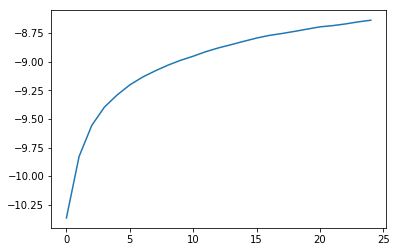

In [10]:
%matplotlib inline
model.plot()

#### Answer here:

`plt.plot(self.logprobs)`

### 4. Simulate a new State of the Union speech

Write a function `new_speech` using the `MyGibbs` class to use the estimated values for $\Phi$ from your model (with stop words removed) to simulate a new State of the Union speech. Start out by simulating $\theta_d \sim Dir(\alpha = 0.5)$ and then simulate your document. Does it make sense? Why, why not?

In [6]:
def new_speech(model, alpha, num_words):
    speech = []
    alpha = [alpha for x in range(model.num_docs)]

    for i in range(num_words):
        theta_d = scipy.random.dirichlet(alpha)
        
        z_dn = np.argmax(scipy.random.multinomial(1, theta_d))
        beta_z = model.term_topics[:][z_dn]
        w_dn = np.argmax(scipy.random.multinomial(1, beta_z/sum(beta_z)))
        speech.append(model.vocab[w_dn])
        
    return " ".join(speech)

In [7]:
new_speech(model, 0.5, 100)

'vice vice 94th 94th members mr vice vice president president distinguished twenty twenty congress vice vice twenty 94th congress distinguished 94th mr vice congress president distinguished speaker speaker twenty members congress twenty members guests speaker members distinguished vice president guests mr mr president mr president congress mr members distinguished 94th twenty president members distinguished mr speaker members mr vice 94th congress guests guests speaker president twenty twenty guests distinguished mr distinguished members mr vice mr congress mr 94th mr members guests 94th distinguished vice twenty mr congress distinguished speaker speaker twenty vice speaker mr mr guests distinguished guests distinguished speaker'

#### Answer here:
First of all we are missing stop words, meaning that the sentence will lack some structure. Also, the model does not caputure structures such as sentences since the model looks at the most frequent words.

### Bonus assignment:

To get better understanding how to implement the underlying model or similar models, you might want to implement your own function to compute the log marginal posterior. If so, implement the `compute_logprob` function.

$$\begin{align}
\log p(\mathbf{z}|\mathbf{w}) =& \log\prod^{K}p(\mathbf{w}|\mathbf{z},\beta)\prod^{D}p(\mathbf{z}|\alpha) \\
=& \sum^{K}\log\left[\frac{\Gamma\left(\sum^{V}\beta\right)}{\prod^{V}\Gamma\left(\beta\right)}\frac{\prod^{V}\Gamma\left(n_{kv}^{(w)}+\beta\right)}{\Gamma(\sum^{V}n_{kv}^{(w)}+\beta)}\right]+\sum^{D}\log\left[\frac{\Gamma\left(\sum^{K}\alpha\right)}{\prod^{K}\Gamma\left(\alpha\right)}\frac{\prod^{K}\Gamma\left(n_{dk}^{(d)}+\alpha\right)}{\Gamma(\sum^{K}n_{dk}^{(d)}+\alpha)}\right] \\
=& K\log\Gamma\left(V\beta\right)-KV\log\Gamma\left(\beta\right)+\sum^{K}\sum^{V}\log\Gamma\left(n_{kv}^{(w)}+\beta\right)-\sum^{K}\log\Gamma(\sum^{V}n_{kv}^{(w)}+\beta)\\
&+ D\log\Gamma\left(K\alpha\right)-DK\log\Gamma\left(\alpha\right)+\sum^{D}\sum^{K}\log\Gamma\left(n_{dk}^{(d)}+\alpha\right)-\sum^{D}\log\Gamma(\sum^{K}n_{dk}^{(d)}+\alpha)
\end{align}$$

In Python, use `scipy.special.gammaln` for $\log\Gamma(x)$ (if you run into problems, you might try `math.lgamma` instead).